# Générer le dataset d'entraînement à partir d'images seules

Cette étape utilise un réseau de neurones de type MiDaS préentraîné pour générer un depth map approximatif des images monoculaires du dataset.

In [1]:
import numpy as np
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

## Définir la source du dataset



In [2]:
# Télécharger une image
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x7f6f575a3b70>)

## Générer les depth maps pour le dataset

### Initialiser le model MiDaS

In [3]:
use_large_model = True

# Télécharger le modèle
if use_large_model:
    midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")
else:
    midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")

# Déplacer le modèle sur le GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)

# Initialiser le modèle
midas.eval();

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_master


Loading weights:  None


### Prétraitement du dataset pour inférence par MiDaS

In [4]:
# Télécharger les transformations incluses avec MiDaS
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if use_large_model:
    transform = midas_transforms.default_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [5]:
# Télécharger le dataset
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Appliquer la normalisation MiDaS et déplacer le dataset vers le GPU
input_batch = transform(img).to(device)

### Prédiction du depth map

In [6]:
with torch.no_grad():
    # Prédire le depth map
    prediction = midas(input_batch)

    # Redimensioner l'image à sa taille originale
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    
Z = prediction.cpu().numpy()

### Test : affichage du résultat

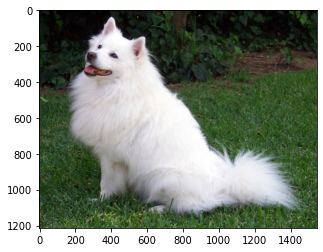

In [7]:
plt.imshow(img)

array([[ 522.86694,  522.7212 ,  522.01416, ...,  582.2361 ,  572.3064 ,
         570.1817 ],
       [ 522.9094 ,  522.76227,  522.0488 , ...,  583.4702 ,  573.80414,
         571.7354 ],
       [ 523.1131 ,  522.95856,  522.20886, ...,  589.70593,  581.38556,
         579.60254],
       ...,
       [3732.836  , 3732.4985 , 3731.0195 , ..., 4290.3115 , 4294.6436 ,
        4295.559  ],
       [3734.3542 , 3734.0735 , 3732.88   , ..., 4294.3174 , 4299.221  ,
        4300.252  ],
       [3734.6953 , 3734.4246 , 3733.282  , ..., 4295.142  , 4300.1577 ,
        4301.2104 ]], dtype=float32)

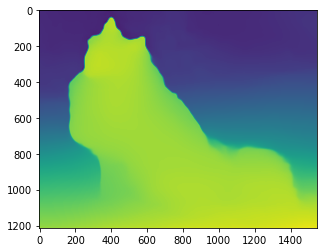

In [8]:
plt.imshow(Z)
Z

## Générer les disparity maps à partir des depth maps

### Générer les disparity maps 

In [9]:
def compute_D_tilde(Z, d_min, d_max):
  s = np.random.randint(d_min, d_max)   # Randomly sampled scaling factor
  print("s:", s)
  Z_max = np.max(Z)
  print("Z_max:", Z_max)
  return (s * Z_max) / Z

s: 18
Z_max: 4420.5137


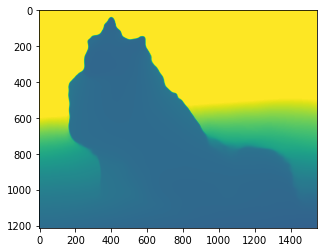

In [10]:
d_min = 0
d_max = 60

D_tilde = compute_D_tilde(Z, d_min, d_max)
D_tilde = np.clip(D_tilde, d_min, d_max)

plt.imshow(D_tilde)

## Générer l'image de droite

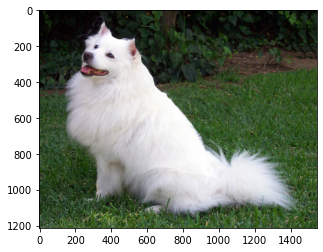

In [11]:
def generate_right_view(img, disp_map, d_max):
  disp_map = disp_map.astype(int)
  # img_r = np.zeros_like(img)
  img_r = img.copy()   # For interpolation
  for p_i in range(img.shape[0]):
    for p_j in range(img.shape[1]):
      # Forward warp
      new_p_j = p_j - disp_map[p_i, p_j]
      if new_p_j > 0:
        img_r[p_i, new_p_j] = img[p_i, p_j]
        # Interpolate
        img_r[p_i, p_j] = img[p_i, p_j]
  return img_r

img_r = generate_right_view(img, D_tilde, d_max)

plt.imshow(img_r)

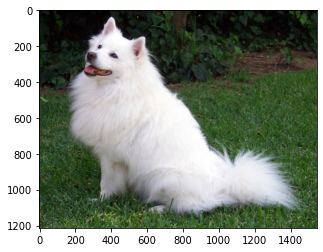

In [12]:
# Test: Compare with original
plt.imshow(img)